# FIDE & Google Efficient Chess AI Challenge

Welcome! This notebook will familiarize you with using competition's environment, creating an agent, and submitting your first chess bot!

In [1]:
# first let's make sure you have internet enabled
import requests
requests.get('http://www.google.com',timeout=10).ok

True

#### If you don't have internet access (it doesn't say "True" above)
1. make sure your account is Phone Verified in [account settings](https://www.kaggle.com/settings)
2. make sure internet is turned on in Settings -> Turn on internet

In [2]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments
!pip install python-chess

In [3]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

[kaggle_environments.envs.open_spiel.open_spiel] INFO: Successfully loaded OpenSpiel environments: 6.
[kaggle_environments.envs.open_spiel.open_spiel] INFO:    open_spiel_chess
[kaggle_environments.envs.open_spiel.open_spiel] INFO:    open_spiel_connect_four
[kaggle_environments.envs.open_spiel.open_spiel] INFO:    open_spiel_gin_rummy
[kaggle_environments.envs.open_spiel.open_spiel] INFO:    open_spiel_go
[kaggle_environments.envs.open_spiel.open_spiel] INFO:    open_spiel_tic_tac_toe
[kaggle_environments.envs.open_spiel.open_spiel] INFO:    open_spiel_universal_poker
[kaggle_environments.envs.open_spiel.open_spiel] INFO: OpenSpiel games skipped: 0.



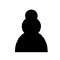
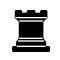
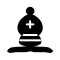
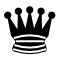
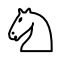
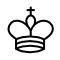
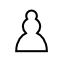
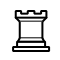
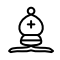
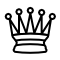
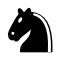
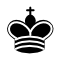

In [4]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=800, height=800) 

### Creating your first agent
Now let's create your first agent! The environment has the [Chessnut](https://github.com/cgearhart/Chessnut) pip package installed and we'll use that to parse the board state and generate moves.

In [5]:
%%writefile main.py
from Chessnut import Game
import chess
import random

pawn_activity_score_white = [[0, 0, 0, 0, 0, 0, 0, 0],
    [50, 50, 50, 50, 50, 50, 50, 50],
    [10, 10, 20, 30, 30, 20, 10, 10],
    [5, 5, 10, 25, 25, 10, 5, 5],
    [0, 0, 0, 20, 20, 0, 0, 0],
    [5, -5, 10, 0, 0, 10, -5, 5],
    [5, 10, 10, -35, -35, 10, 10, 5],
    [0, 0, 0, 0, 0, 0, 0, 0]]

knight_activity_score_white = [[-50, -40, -30, -30, -30, -30, -40, -50],
                            [-40, -20, 0, 0, 0, 0, -20, -40],
                            [-30, 0, 10, 15, 15, 10, 0, -30],
                            [-30, 5, 15, 20, 20, 15, 5, -30],
                            [-30, 0, 15, 20, 20, 15, 0, -30],
                            [-30, 5, 10, 15, 15, 10, 5, -30],
                            [-40, -20, 0, 5, 5, 0, -20, -40],
                            [-50, -40, -30, -30, -30, -30, -40, -50]]
bishop_activity_score_white = [[-20,-10,-10,-10,-10,-10,-10,-20],
[-10,  0,  0,  0,  0,  0,  0,-10],
[-10,  0,  5, 10, 10,  5,  0,-10],
[-10,  5,  5, 10, 10,  5,  5,-10],
[-10,  0, 10, 10, 10, 10,  0,-10],
[-10, 10, 10, 10, 10, 10, 10,-10],
[-10,  5,  0,  0,  0,  0,  5,-10],
[-20,-10,-10,-10,-10,-10,-10,-20]]

rook_activity_score_white = [[0,  0,  0,  0,  0,  0,  0,  0],
  [5, 10, 10, 10, 10, 10, 10,  5],
 [-5,  0,  0,  0,  0,  0,  0, -5],
 [-5,  0,  0,  0,  0,  0,  0, -5],
 [-5,  0,  0,  0,  0,  0,  0, -5],
 [-5,  0,  0,  0,  0,  0,  0, -5],
 [-5,  0,  0,  0,  0,  0,  0, -5],
  [0,  0,  0,  5,  5,  0,  0,  0]]

queen_activity_score_white = [[-20,-10,-10, -5, -5,-10,-10,-20],
[-10,  0,  0,  0,  0,  0,  0,-10],
[-10,  0,  5,  5,  5,  5,  0,-10],
 [-5,  0,  5,  5,  5,  5,  0, -5],
  [0,  0,  5,  5,  5,  5,  0, -5],
[-10,  5,  5,  5,  5,  5,  0,-10],
[-10,  0,  5,  0,  0,  0,  0,-10],
[-20,-10,-10, -5, -5,-10,-10,-20]]

king_activity_score_white = [[-30,-40,-40,-50,-50,-40,-40,-30],
[-30,-40,-40,-50,-50,-40,-40,-30],
[-30,-40,-40,-50,-50,-40,-40,-30],
[-30,-40,-40,-50,-50,-40,-40,-30],
[-20,-30,-30,-40,-40,-30,-30,-20],
[-10,-20,-20,-20,-20,-20,-20,-10],
 [20, 20,  0,  0,  0,  0, 20, 20],
 [20, 30, 10,  0,  0, 10, 30, 20]]

pawn_activity_score_black = pawn_activity_score_white[::-1]
knight_activity_score_black = knight_activity_score_white[::-1]
bishop_activity_score_black = bishop_activity_score_white[::-1]
rook_activity_score_black = rook_activity_score_white[::-1]
queen_activity_score_black = queen_activity_score_white[::-1]
king_activity_score_black = king_activity_score_white[::-1]

def evaluate(board):
    # Piece values
    piece_values = {
        chess.PAWN:   100,
        chess.KNIGHT: 320,
        chess.BISHOP: 330,
        chess.ROOK:   500,
        chess.QUEEN:  900,
        chess.KING:   0  # King value not needed for material eval
    }

    # Activity tables (already defined in your code)
    piece_tables = {
        chess.PAWN:   (pawn_activity_score_white, pawn_activity_score_black),
        chess.KNIGHT: (knight_activity_score_white, knight_activity_score_black),
        chess.BISHOP: (bishop_activity_score_white, bishop_activity_score_black),
        chess.ROOK:   (rook_activity_score_white, rook_activity_score_black),
        chess.QUEEN:  (queen_activity_score_white, queen_activity_score_black),
        chess.KING:   (king_activity_score_white, king_activity_score_black)
    }

    score = 0

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        
        if piece:
            value = piece_values[piece.piece_type]
            row = square // 8
            col = square % 8
            if piece.color == chess.WHITE:
                activity = piece_tables[piece.piece_type][0][7 - row][col]
                score += value + activity
            else:
                activity = piece_tables[piece.piece_type][1][row][col]
                score -= value + activity

    # Bonus for check / penalty for being checked
    if board.is_check():
        if board.turn == chess.WHITE:
            score -= 50
        else:
            score += 50

    return score

def quiescence(board, alpha, beta, color):
    stand_pat = color * evaluate(board)
    if stand_pat >= beta:
        return beta
    if alpha < stand_pat:
        alpha = stand_pat

    # Explore only captures
    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)
            score = -quiescence(board, -beta, -alpha, -color)
            board.pop()

            if score >= beta:
                return beta
            if score > alpha:
                alpha = score
    return alpha


def negamax(board, depth, alpha, beta, color):
    if board.is_checkmate():
        return -99999 + depth
    if board.is_stalemate() or board.is_insufficient_material() or board.can_claim_threefold_repetition():
        return 0

    #if depth == 0:
    #    return quiescence(board, alpha, beta, color)

    if depth == 0:
        return color * evaluate(board)

    max_eval = -float('inf')

    def move_score(move):
        if board.is_capture(move):
            return 10
        elif board.gives_check(move):
            return 5
        else:
            return 0

    legal_moves = sorted(board.legal_moves, key=move_score, reverse=True)

    for move in legal_moves:
        board.push(move)
        eval = -negamax(board, depth - 1, -beta, -alpha, -color)
        board.pop()

        if eval > max_eval:
            max_eval = eval
        alpha = max(alpha, eval)
        if alpha >= beta:
            break

    return max_eval

    
def analyze(fen, depth=2):
    board = chess.Board(fen)
    best_score = -float('inf')
    best_move = None

    for move in board.legal_moves:
        board.push(move)
        score = -negamax(board, depth - 1, -float('inf'), float('inf'), 1 if board.turn == chess.WHITE else -1)
        board.pop()

        if score > best_score:
            best_score = score
            best_move = move

    if best_move:
        return best_move.uci(), best_score
    else:
        return None, 0

import time

def iterative_deepening_search(board, max_depth, time_limit=2.0):
    start_time = time.time()
    best_move = None
    color = 1 if board.turn == chess.WHITE else -1

    for depth in range(1, max_depth + 1):
        if time.time() - start_time > time_limit:
            break

        max_eval = -float('inf')
        alpha = -float('inf')
        beta = float('inf')

        # Sort moves to improve pruning
        def move_score(move):
            if board.is_capture(move):
                return 10
            elif board.gives_check(move):
                return 5
            else:
                return 0

        legal_moves = sorted(board.legal_moves, key=move_score, reverse=True)

        for move in legal_moves:
            board.push(move)
            eval = -negamax(board, depth - 1, -beta, -alpha, -color)
            board.pop()

            if eval > max_eval:
                max_eval = eval
                best_move = move

            if time.time() - start_time > time_limit:
                break

    return best_move.uci() if best_move else None



def chess_bot(obs):
    """
    Simple chess bot that prioritizes checkmates, then captures, queen promotions, then randomly moves.

    Args:
        obs: An object with a 'board' attribute representing the current board state as a FEN string.

    Returns:
        A string representing the chosen move in UCI notation (e.g., "e2e4")
    """
    # 0. Parse the current board state and generate legal moves using Chessnut library
    game = Game(obs.board)

    # 2. Find the optimal move based off an evaluation
    board = chess.Board(obs.board)
    alpha = -float("inf")
    beta = float("inf")
    depth = 2
    best_move = iterative_deepening_search(board, depth)

    return best_move

    # 3. Check for queen promotions
    for move in moves:
        if "q" in move.lower():
            return move

    # 4. Random move if no checkmates or captures
    return random.choice(moves)


Writing main.py


In [6]:
%%writefile main_starter.py
from Chessnut import Game
import random

def chess_bot(obs):
    """
    Simple chess bot that prioritizes checkmates, then captures, queen promotions, then randomly moves.

    Args:
        obs: An object with a 'board' attribute representing the current board state as a FEN string.

    Returns:
        A string representing the chosen move in UCI notation (e.g., "e2e4")
    """
    # 0. Parse the current board state and generate legal moves using Chessnut library
    game = Game(obs.board)
    moves = list(game.get_moves())

    # 1. Check a subset of moves for checkmate
    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    # 2. Check for captures
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move

    # 3. Check for queen promotions
    for move in moves:
        if "q" in move.lower():
            return move

    # 4. Random move if no checkmates or captures
    return random.choice(moves)

Writing main_starter.py


### Testing your agent

Now let's see how your agent does againt the random agent!

Agent exit status/reward/time left: 
	 DONE / 1 / 2.3825050000000014
	 DONE / 0 / 9.998221





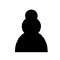
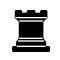
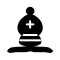
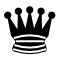
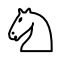
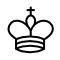
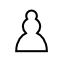
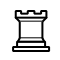
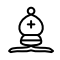
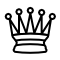
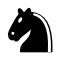
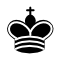

In [7]:
result = env.run(["main.py", "main_starter.py"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=700, height=700) 

# To Submit:
1. Download (or save) main.py
2. Go to the [submissions page](https://www.kaggle.com/competitions/fide-google-efficiency-chess-ai-challenge/submissions) and click "Submit Agent"
3. Upload main.py
4. Press Submit!

Now doubt you are already thinking of ways this bot could be improved! Go ahead and fork this notebook and get started! ♟️

# Submitting Multiple files 
### (or compressing your main.py)

Set up your directory structure like this:
```
kaggle_submissions/
  main.py
  <other files as desired>
```

You can run `tar -czf submission.tar.gz -C kaggle_submissions .` and upload `submission.tar.gz`